<a href="https://colab.research.google.com/github/gkianfar/TIHM-Dataset-Visualization/blob/main/TIHM_data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install joypy

**Loading Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/gkianfar/TIHM-Dataset-Visualization.git

Cloning into 'TIHM-Dataset-Visualization'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 9), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 8.72 MiB | 6.78 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
from joypy import joyplot
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from joypy import joyplot
#from utils.data_utils import correct_col_type,gen_date_col,transform_category_to_counts,gen_summary
#from utils.vis_utils import vis_day_counts_ridge_plot,save_fig,vis_personal_aligned_multiview_day_plot

In [5]:
def concat_slist(slist):
    s = ''
    for vs in slist:
        s+= str(vs)+','
    return s

def correct_col_type(df,col):
    raw_type = str(type(df[col].dtype)).split('.')[-1].split('\'')[0].lower()
    #print(col,raw_type)
    if 'object' in raw_type:
        if 'date' in col or 'timestamp' in col or 'datetime' in col:
            return pd.to_datetime(df[col])
        else:
            return df[col].astype('category')
    else:
        return df[col]


def gen_date_col(df, tcol):
    df['date'] = pd.to_datetime(df[tcol].dt.date)
    return df

def transform_category_to_counts(df,col,keys):
    tmp = df.groupby([col]+ keys).size().to_frame('size').reset_index().pivot_table(values = 'size', columns=col, index=keys)
    tmp = tmp.drop(tmp.index[tmp.values.sum(axis=1)==0],axis=0).reset_index()
    return tmp


def get_personal_df(df,pid):
    if not 'patient_id' in df.columns:
        df = df.reset_index()
    tmp = df.loc[df.patient_id==pid].drop('patient_id',axis=1)

    return tmp



def min_max_perpatient(df,skip=[]):
    for pid in df.patient_id.unique():
        ptmp = df.loc[df.patient_id==pid]
        for c in ptmp.columns:
            if 'int' in str(ptmp[c].dtype) or 'float' in str(ptmp[c].dtype):
                if ptmp[c].notna().sum() > 0 and c not in skip:
                    min_v = np.nanmin(ptmp[c].values)
                    max_v = np.nanmax(ptmp[c].values)
                    if max_v > min_v:
                        df.loc[df.patient_id==pid,c] = (ptmp[c].values-min_v)/(max_v-min_v)
                    elif max_v!=0:
                        df.loc[df.patient_id==pid,c] = 0.5 #only one record
    return df


def gen_summary(df):

  sm = pd.DataFrame(columns=['Value Type','Value Number','Description'])

  for stc in df.columns:
      sm.loc[stc,'Value Type'] = str(type(df[stc].dtype)).split('.')[-1].split('\'')[0].lower()
      if 'categorical' in sm.loc[stc,'Value Type'] or 'object' in sm.loc[stc,'Value Type']:
          vset = set(df[stc].values)
          sm.loc[stc, 'Value Number'] = len(vset)
          dl = len(vset) if 5 > len(vset) else 5
          if 'id' in stc:
              sm.loc[stc,'Description'] = 'hash code'
          else:
              sm.loc[stc,'Description'] = concat_slist(list(vset)[:dl])
      elif 'datetime' in sm.loc[stc,'Value Type'].lower():
          sm.loc[stc,'Description'] = 'from '+ str(df[stc].min()) + ' to ' + str(str(df[stc].max()))
      elif 'float' in sm.loc[stc,'Value Type'] or 'int' in sm.loc[stc,'Value Type']:
          sm.loc[stc,'Description'] = 'min: ' + str(df[stc].min()) + ', max: ' + str(str(df[stc].max()))
      elif 'bool' in sm.loc[stc,'Value Type']:
          sm.loc[stc, 'Value Number'] = 2
          sm.loc[stc,'Description'] = 'True or False'

  return sm

In [6]:
#from .data_utils import *

def save_fig(fname,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,fname),bbox_inches='tight')

def save_personal_fig(pid,fname,save_path):
    save_path = os.path.join(save_path,pid)
    save_fig(fname,save_path)

def add_personal_label_markers(labels_df,pid,ax,max_v,add_marker=True,marker_color='orchid',
                               add_lgd=True,lgd_loc=[1.01,0.75],min_v=0):

    lbs = labels_df.loc[labels_df.patient_id==pid]
    lmarkers = ['*','s','^','o','P','p','h','D']
    lax, lax_lgd = [], []

    if add_marker:
        for i,l in enumerate(lbs.type.values.categories):
            ltmp = lbs.loc[lbs.type==l]
            if len(ltmp)>0:
                ll = ax.plot(ltmp['date'],[max_v]*len(ltmp),lmarkers[i],color=marker_color)
                lax.append(ll[0])
                lax_lgd.append(l)

    for i in range(len(lbs)):
        ax.plot([lbs.date.values[i],lbs.date.values[i]],[min_v,max_v],'--',color='C7')

    if add_lgd:
        lb_patch = mpatches.Patch(color='orchid')
        lbl_lgd = ax.legend([lb_patch]+lax, ['Alerts']+lax_lgd, loc=lgd_loc,fontsize=9)
        ax.add_artist(lbl_lgd)
        return None, None
    else:
        return lax,lax_lgd


def dsample_xticks(N,m=10):
    gap = N/m
    idx = [int(i*gap) for i in range(m)]
    if N%m>0:
        idx+=[N-1]
    return idx


def draw_day_ridge_plot(day_df,ax=None,xticks=None):
    x_range = np.arange(day_df.shape[0])
    f, axes = joyplot(day_df,kind="values",x_range=x_range,overlap = 0.5, colormap=cm.Blues_r,
                      fade=True,figsize=[10,4],linewidth=0.25,alpha=0.6,ax=ax)

    if xticks is None:
        idx = dsample_xticks(day_df.shape[0],m=10)

        axes[-1].set_xticks(x_range[idx],labels=day_df.index[idx])
    else:
        axes[-1].set_xticks(xticks[0],xticks[1])
    return


def vis_day_counts_ridge_plot(raw_df,col,title,fname,save_path='./figs/',drop_list=None,
                              transform=False,ax=None,xticks=None):
    if transform:
        tmp = raw_df.groupby([col, 'date']).size().to_frame('size').reset_index().pivot_table(values = 'size', columns=col, index='date')
    else:
        tmp = raw_df.groupby('date')[act_df.select_dtypes(include=['number']).columns].sum()

    if drop_list is not None:
        tmp = tmp.drop(drop_list,axis=1)
    draw_day_ridge_plot(tmp,ax=ax,xticks=xticks)
    plt.title(title)
    save_fig(fname,save_path=save_path)


def get_personal_sleep_day_df(sleep_df,pid):

    sleep_states = ['AWAKE', 'LIGHT', 'DEEP', 'REM']
    sleep_df = sleep_df.set_index('date')
    sdtmp = get_personal_df(sleep_df,pid).loc[:,sleep_states]#get_personal_agg_info_df(sleep_df,pid,cols=sleep_states,keys=['date'],agg_fn='sum')
    pdtmp = get_personal_df(sleep_df,pid).loc[:,['heart_rate','respiratory_rate']] #get_personal_agg_info_df(sleep_df,pid,cols=['heart_rate','respiratory_rate'],keys=['date'],agg_fn='max')

    return sdtmp,pdtmp

def vis_personal_aligned_multiview_day_plot(phys_df,pgrps,pid,save_path,sleep_df=None,act_df=None,
                                            labels_df=None,ftype='svg',xticks=None):

    sns.set_style("whitegrid",{'axes.grid': True,'grid.linestyle': '--', 'axes.spines.left':False,
                            'axes.spines.right':False,'axes.spines.top':False})
    cmap = sns.color_palette('colorblind')#cm.get_cmap('tab10').colors

    #sleep_states = sleep_df['state'].unique()
    if sleep_df is not None:
        sdtmp, _ = get_personal_sleep_day_df(sleep_df,pid)
    if act_df is not None:
        adtmp = transform_category_to_counts(act_df,col='location_name',keys=['patient_id','date'])

        adtmp = get_personal_df(adtmp,pid)
        adtmp = adtmp.set_index('date')
        adtmp['total'] = adtmp.sum(axis=1)

    if sleep_df is not None and len(sdtmp) > 0 and act_df is not None:
        adtmp,sdtmp = align_dates(adtmp,sdtmp)



    pdtmp = get_personal_df(phys_df,pid)
    #pdtmp = pdtmp.set_index('date')
    if act_df is not None:
        pdtmp.drop(pdtmp.loc[(pdtmp.date<adtmp.index.values.min())|(pdtmp.date>adtmp.index.values.max())].index,axis=0,inplace=True)
    pv = pd.pivot_table(pdtmp, values='value', index=['date'],
                    columns=['device_type'])
    pv = pv.rename(columns={'Skin Temperature':'Skin temperature','Body Temperature':'Body temperature'})
    pvs = []
    for i,pgrp in enumerate(pgrps.values()):
        pgrp = list(set(pgrp) & set(pv.columns))
        if len(pgrp)>0:
            pvi = pv[pgrp]
            pvi = pvi.drop(pvi.columns[pvi.values.sum(axis=0)==0],axis=1)
            pvs.append(pvi)



    nr = len(pvs)+1 if act_df is not None else len(pvs)
    f, axs = plt.subplots(nr, 1,gridspec_kw={'height_ratios': [1]*nr},figsize=[10,3*nr],sharex=True)

    ci = 0
    axi = 0
    if act_df is not None:
        aax = axs[0].fill_between(x=adtmp.index,y1=np.zeros(adtmp.shape[0]),y2=adtmp['total'].values,alpha=0.4,color=cmap[ci])
        handles = [aax]
        max_v = adtmp.values.max()
        lgd = ['Acitivity counts']
        ci+=1
        if sleep_df is not None and len(sdtmp) > 0:
            sdtmp['total'] = sdtmp.sum(axis=1)
            sax = axs[0].fill_between(x=sdtmp.index,y1=np.zeros(sdtmp.shape[0]),y2=sdtmp['total'].values,alpha=0.4,color=cmap[ci])
            ci+=1
            handles.append(sax)
            max_v = max(max_v,sdtmp.values.max())
            lgd.append('Sleep duration (minutes)')

        axs[0].tick_params(labelbottom=True)
        axi += 1

    if labels_df is not None:
        if act_df is not None:
            labels_df = labels_df.drop(labels_df.loc[(labels_df.date<adtmp.index.values.min())|(labels_df.date>adtmp.index.values.max())].index,axis=0)
        labels_df = labels_df.loc[labels_df['patient_id']==pid]
        if len(labels_df)==0:
            labels_df = None

    if labels_df is not None and axi >0:
        add_personal_label_markers(pid=pid,ax=axs[0],max_v=max_v,
                                   labels_df=labels_df,lgd_loc=[1.01,0.5],add_lgd=True)
        axs[0].legend(handles,lgd,loc=[1.01,0.1])



    for i,pvi in enumerate(pvs):

        lls = axs[i+axi].plot(pvi.index,pvi.values,'.-')
        for l in lls:
            l.set_color(cmap[ci])
            ci+=1

        axs[i+axi].tick_params(labelbottom=True)

        max_v = pvi.fillna(0).values.max()*1.1
        min_v = pvi.fillna(999).values.min()*0.9

        if labels_df is not None:
            if i+axi>0:
                add_personal_label_markers(pid=pid,ax=axs[i+axi],max_v=max_v,
                                       labels_df=labels_df,add_marker=True,add_lgd=False,min_v=min_v)
            else:
                add_personal_label_markers(pid=pid,ax=axs[0],max_v=max_v,
                                   labels_df=labels_df,lgd_loc=[1.01,0.5],add_lgd=True)

        axs[i+axi].legend(pvi.columns,loc=[1.01,0.1])

    if xticks is None:
        if act_df is None:
            xidx = dsample_xticks((pvs[0].index[-1]-pvs[0].index[0]).days,m=8)
            xticks = [pvs[0].index.values[0]+pd.Timedelta(xi,'D') for xi in xidx]
        else:
            xidx = dsample_xticks((adtmp.index[-1]-adtmp.index[0]).days,m=8)
            xticks = [adtmp.index.values[0]+pd.Timedelta(xi,'D') for xi in xidx]
        axs[0].set_xticks(xticks,labels=xticks)

    else:
        axs[0].set_xticks(xticks,labels=xticks)

    #axs[0].set_title('Patient '+str(pid)+' aligned multiview day trend')
    save_personal_fig(pid=pid,fname='personal_multiview_day_plot.'+ftype,save_path=save_path)





In [7]:
## Please change the path with the path of your dataset
DPATH = '/content/TIHM-Dataset-Visualization/Data'
SAVE_PATH = '/content/TIHM-Dataset-Visualization/Figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [81]:
## Read all tables into data_dict and generate table summaries
files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)

    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})
        df['date'] = pd.to_datetime(df['timestamp'].dt.date)

    fname = f.split('.')[0]
    data_dict[fname] = df
    summaries[fname] = gen_summary(df)

Labels.csv
Demographics.csv
Activity.csv
Physiology.csv
Sleep.csv


In [ ]:
for name, data in data_dict.items():
  print(f'__________________{name} data:\n ________________')
  print(f'{data.head()} \n summary: \n {summaries[name]}')
  print('________________________________________')

__________________Sleep data:
 ________________
  patient_id           timestamp  state  heart_rate  respiratory_rate  \
0      0f352 2019-06-25 22:53:00  AWAKE        69.0              14.0   
1      0f352 2019-06-25 22:54:00  AWAKE        66.0              14.0   
2      0f352 2019-06-25 22:55:00  AWAKE        70.0              14.0   
3      0f352 2019-06-25 22:56:00  AWAKE        70.0              13.0   
4      0f352 2019-06-25 22:57:00  AWAKE        68.0              13.0   

   snoring       date  
0    False 2019-06-25  
1    False 2019-06-25  
2    False 2019-06-25  
3    False 2019-06-25  
4    False 2019-06-25   
 summary: 
                         Value Type Value Number  \
patient_id        categoricaldtype           17   
timestamp          datetime64dtype          NaN   
state             categoricaldtype            4   
heart_rate            float64dtype          NaN   
respiratory_rate      float64dtype          NaN   
snoring                  booldtype            2   

In [ ]:
df = data_dict['Sleep']
patients = df.patient_id.unique()
missing={}
for pid in patients:

  p_df = get_personal_df(df,pid).copy()
  dates = p_df.date.unique()
  missed_monitor = 0
  mins=[]
  maxs=[]
  diffs=[]
  missed_monitor = []
  monitored = []
  for d in dates:
    p_df_date = p_df.loc[p_df['date']==d].copy()
    min = p_df_date['timestamp'].min()
    max = p_df_date['timestamp'].max()
    diff = max - min
    mins.append(min)
    maxs.append(max)
    diffs.append(diff)

    new_index = pd.date_range(start=min,end=max,freq='1min')
    #print(f'min: {min} - max: {max}')

    p_df_date.set_index('timestamp',inplace=True)
    p_df_date = p_df_date.reindex(new_index)
    rows_with_nan = p_df_date[p_df_date.isna().any(axis=1)]
    rows_without_nan = p_df_date[~p_df_date.isna().any(axis=1)]
    #print(rows_with_nan)
    #print(rows_without_nan)
    missed_monitor.append(rows_with_nan.shape[0])
    monitored.append(rows_without_nan.shape[0])
  missing[pid] = pd.DataFrame({'date':dates,'min':mins,'max':maxs,
                      'diff':diffs,'monitored':monitored,
                               'missed':missed_monitor})
  mind = missing[pid].date.min()
  maxd = missing[pid].date.max()
  new_indexd = pd.date_range(start=mind,end=maxd,freq='1D')
  missing[pid].set_index('date',inplace=True)
  missing[pid] = missing[pid].reindex(new_indexd)

  #print(f'{pid}: {missed_monitor}')
  #missing[pid] = missed_monitor

In [ ]:
%matplotlib inline
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

In [ ]:
pd.DataFrame(missing[pid])

,date,min,max,diff,missed
0,2019-05-07,2019-05-07 17:05:00,2019-05-07 23:59:00,0 days 06:54:00,12
1,2019-05-08,2019-05-08 00:00:00,2019-05-08 23:59:00,0 days 23:59:00,642
2,2019-05-09,2019-05-09 00:00:00,2019-05-09 23:59:00,0 days 23:59:00,786
3,2019-05-10,2019-05-10 00:00:00,2019-05-10 23:59:00,0 days 23:59:00,807
4,2019-05-11,2019-05-11 00:00:00,2019-05-11 23:58:00,0 days 23:58:00,713
5,2019-05-12,2019-05-12 00:02:00,2019-05-12 23:59:00,0 days 23:57:00,859
6,2019-05-13,2019-05-13 00:00:00,2019-05-13 23:59:00,0 days 23:59:00,779
7,2019-05-14,2019-05-14 00:00:00,2019-05-14 23:59:00,0 days 23:59:00,759
8,2019-05-15,2019-05-15 00:00:00,2019-05-15 23:59:00,0 days 23:59:00,743
9,2019-05-16,2019-05-16 00:00:00,2019-05-16 23:59:00,0 days 23:59:00,810


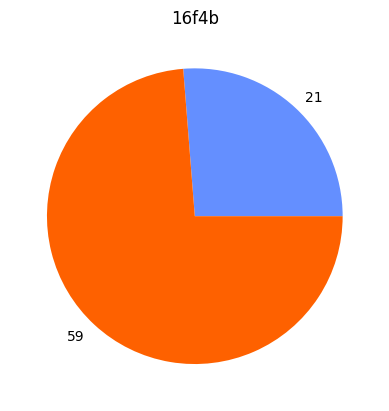

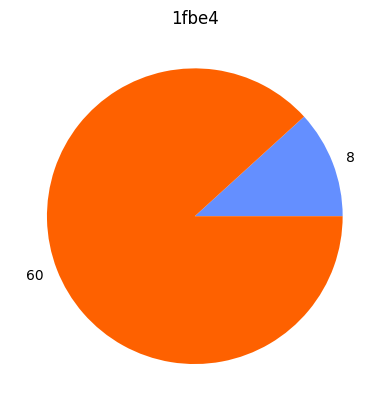

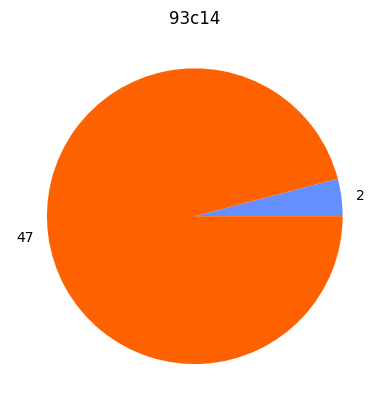

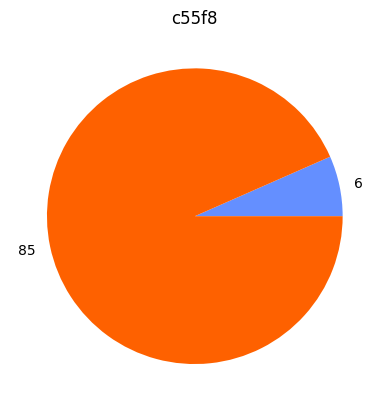

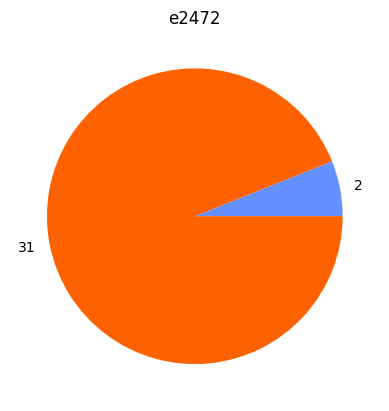

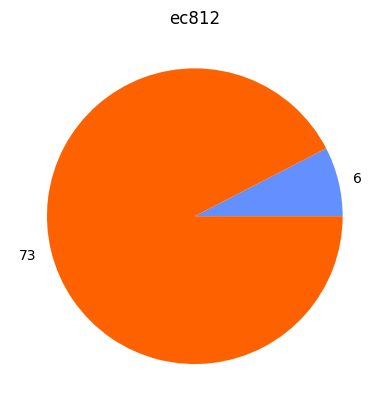

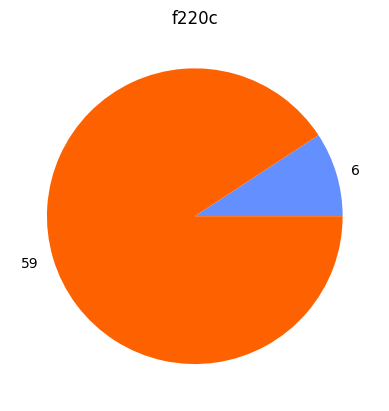

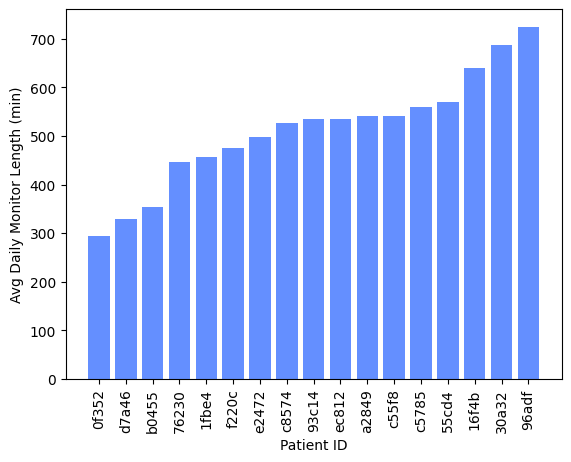

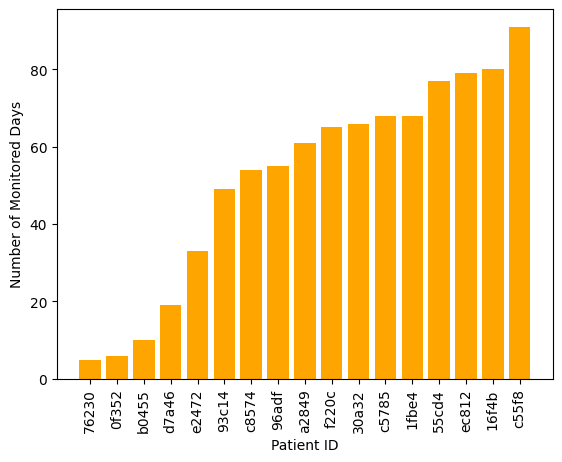

In [ ]:
monitor_avg = {}
dates_missed = {}
dates_monitored = {}

for pid in patients:
  monitor_avg[pid] = missing[pid].monitored.mean()
  dates_missed[pid] = missing[pid].loc[missing[pid]['min'].isna()].index.nunique()
  dates_monitored[pid] = missing[pid].loc[~missing[pid]['min'].isna()].index.nunique()

for pid in patients:
  if dates_missed[pid]>0:
    fig, ax = plt.subplots(1)
    ax.pie([dates_missed[pid],dates_monitored[pid]], labels=[dates_missed[pid],dates_monitored[pid]])
    ax.set_title(f'{pid}')
    fig.savefig(f'{SAVE_PATH}/{pid}_sleep_missing_pie.png')
fig, ax = plt.subplots(1)
sorted_indices = np.argsort(list(monitor_avg.values()))
x = np.array(list(monitor_avg.keys()))[sorted_indices]  # Sorted keys
y = np.array(list(monitor_avg.values()))[sorted_indices]  # Sorted values
ax.bar(x,y)
ax.set_ylabel('Avg Daily Monitor Length (min)')
ax.set_xlabel('Patient ID')
ax.set_xticks(range(len(monitor_avg.keys())),x, rotation='vertical')
fig.savefig(f'{SAVE_PATH}/sleep_daily_monitor.png')

fig, ax = plt.subplots(1)
y = []
x = []

# Populate x and y
for k, v in dates_missed.items():
    y.append(dates_monitored[k] + v)
    x.append(k)

# Convert to NumPy arrays for sorting
y = np.array(y)
x = np.array(x)
sorted_indices = np.argsort(y)
y = y[sorted_indices]
x = x[sorted_indices] # Sorted keys
ax.bar(x,y,color='orange')
ax.set_ylabel('Number of Monitored Days')
ax.set_xlabel('Patient ID')
ax.set_xticks(range(len(x)),x, rotation='vertical')
fig.savefig(f'{SAVE_PATH}/sleep_date_monitor.png')

In [ ]:
patients_activity = data_dict['Activity'].patient_id.unique()
patients_physiology = data_dict['Physiology'].patient_id.unique()
patients_labels = data_dict['Labels'].patient_id.unique()
patients_sleep = data_dict['Sleep'].patient_id.unique()

total_patients = list(set(np.concatenate((patients_activity,
                                  patients_physiology,
                                      patients_labels,
                                         patients_sleep))))
num_total_patients = len(total_patients)
df = pd.DataFrame({'activity':np.zeros(num_total_patients),
                   'physiology':np.zeros(num_total_patients),
                   'labels':np.zeros(num_total_patients),
                   'sleep':np.zeros(num_total_patients)},index=total_patients)
for p in total_patients:
  df.loc[p,"activity"] = 1 if p in patients_activity else 0
  df.loc[p,"physiology"] = 1 if p in patients_physiology else 0
  df.loc[p,"labels"] = 1 if p in patients_physiology else 0
  df.loc[p,"sleep"] = 1 if p in patients_sleep else 0
df

,activity,physiology,labels,sleep
ab47a,1.0,1.0,1.0,0.0
95899,1.0,1.0,1.0,0.0
c55f8,1.0,1.0,1.0,1.0
76230,1.0,1.0,1.0,1.0
56b6b,1.0,1.0,1.0,0.0
c5785,1.0,1.0,1.0,1.0
e87bd,1.0,1.0,1.0,0.0
7db78,1.0,1.0,1.0,0.0
f220c,1.0,1.0,1.0,1.0
2b131,1.0,1.0,1.0,0.0


Text(0, 0.5, 'Number of Paticipants')

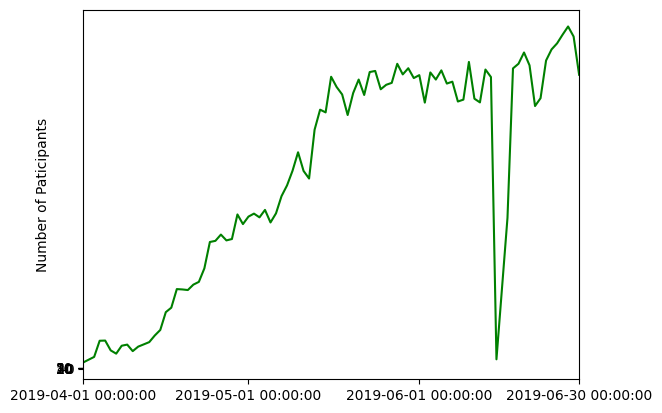

In [ ]:
## Visualise number of paticipants with time
p_ct=data_dict['Activity'].groupby('date').agg(size=('patient_id','size'))
plt.figure()
plt.plot(p_ct,color='g')
idx = [0,29,60,88]
plt.xticks(p_ct.index[idx],labels=p_ct.index[idx])

plt.xlim(p_ct.index[0],p_ct.index[-1])
plt.yticks(np.arange(0,60,10))
plt.ylabel('Number of Paticipants')

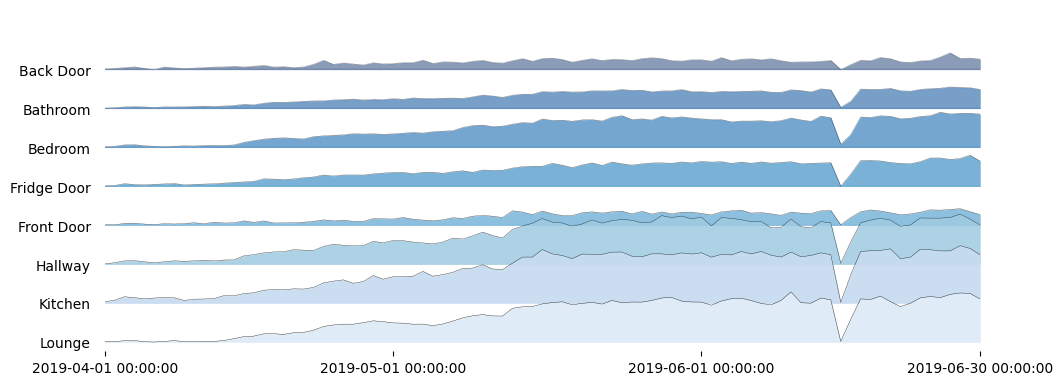

In [ ]:
## Visualise location-activity with time
act_df = transform_category_to_counts(data_dict['Activity'],col='location_name',keys=['patient_id','date'])
all_act = act_df.groupby('date')[act_df.select_dtypes(include=['number']).columns].sum()
vis_day_counts_ridge_plot(act_df,'location_name',title='',
                          fname='all_activity_ridgeplot.svg',save_path=SAVE_PATH,
                          xticks=([0,29,60,88],all_act.index[[0,29,60,-1]]))


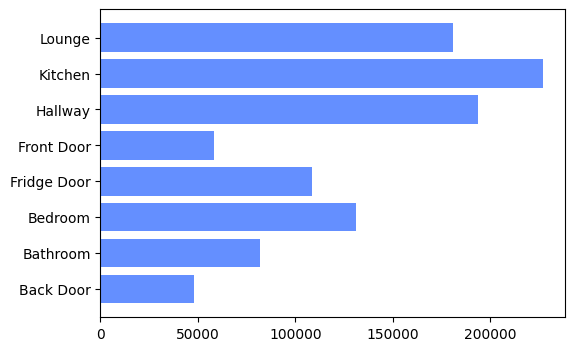

In [ ]:
## Visualise total counts of each location
tmp = act_df.groupby('date')[act_df.select_dtypes(include=['number']).columns].sum()
plt.figure(figsize=[6,4])
bars = plt.barh(width=tmp.sum(axis=0),y=tmp.columns)

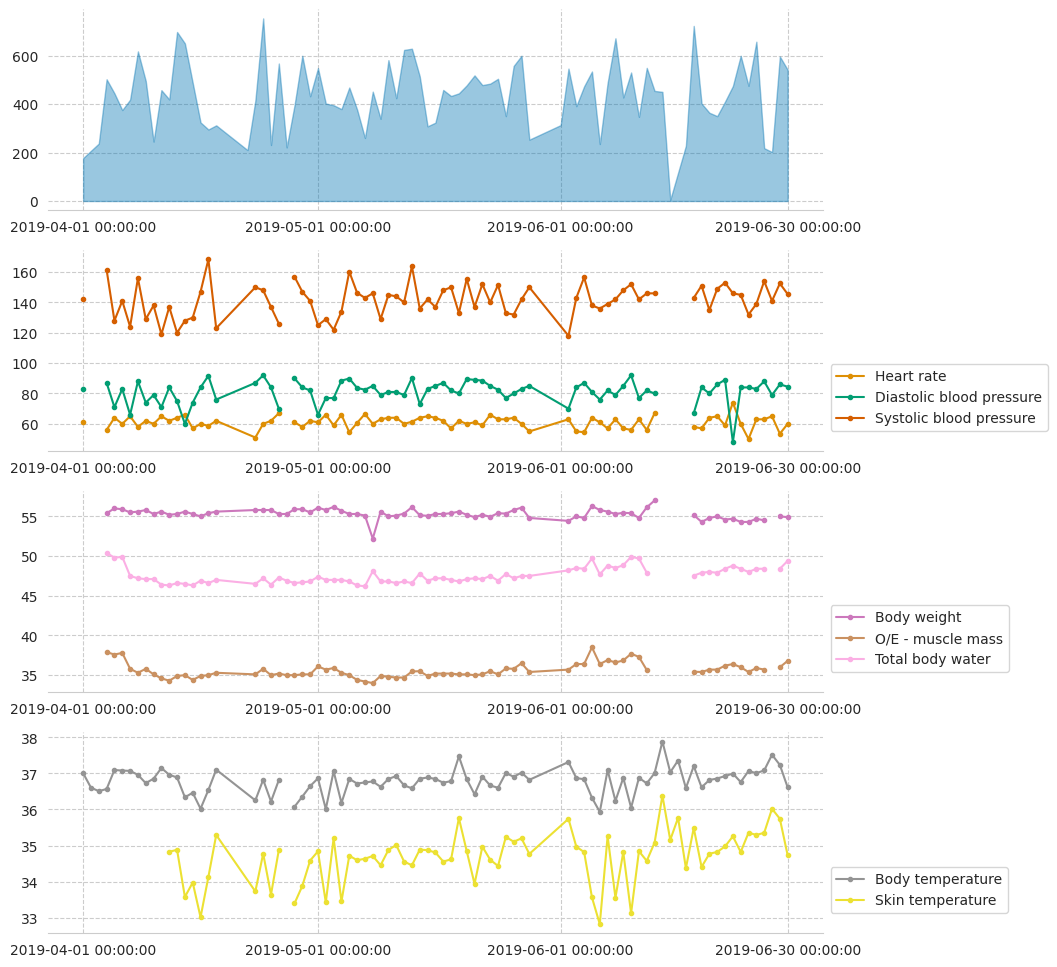

In [ ]:
## Visualize Physiology measurements align with labels for an individual participant
pgrps = {'pgrp1': ['Systolic blood pressure','Diastolic blood pressure', 'Heart rate'],
            'pgrp2' : ['O/E - muscle mass', 'Total body water', 'Body weight'],
            'pgrp3' : [ 'Skin temperature','Body temperature']}
numerical_cols = data_dict['Physiology'].select_dtypes(include=[np.number]).columns
phys = data_dict['Physiology'].groupby(['patient_id','date','device_type'])[numerical_cols].agg('max')
phys.drop(phys.loc[phys.sum(axis=1)==0].index,axis=0,inplace=True)
phys.reset_index(inplace=True)
x_idx = phys.groupby('date')[phys.select_dtypes(include=['number']).columns].mean().index


vis_personal_aligned_multiview_day_plot(sleep_df=None,
                                        act_df=data_dict['Activity'],
                                        phys_df=data_dict['Physiology'],
                                        pgrps=pgrps,
                                        pid='c55f8',
                                        save_path=SAVE_PATH,
                                        labels_df=None,
                                        ftype='pdf',xticks=x_idx[[0,30,61,90]])

In [ ]:
def calculate_freq(x):
    # Ensure x has at least two elements
    if len(x) < 2:
        return None
    return (x.max() - x.min()).total_seconds() / (len(x) - 1)

pid = 'c55f8'
phy_df = get_personal_df(data_dict['Physiology'], pid)
devices = phy_df['device_type'].unique()
# Pivot table creation
phy_df = pd.pivot_table(
    phy_df,
    values=['value'],
    columns=['device_type'],
    index='timestamp'
).reset_index()  # Reset index to bring 'timestamp' back as a column
freq = {}
for d in devices:
  # Group by 'date' and calculate frequency
  freq[d] = phy_df['timestamp'].loc[~phy_df['value'][d].isna()].diff().median()
freq_df = pd.DataFrame(list(freq.items()), columns=['device_type', 'freq'])
freq_df

,device_type,freq
0,Body Temperature,0 days 00:59:55
1,Systolic blood pressure,0 days 23:01:27
2,Diastolic blood pressure,0 days 23:01:27
3,Heart rate,0 days 23:01:27
4,O/E - muscle mass,0 days 23:58:51
5,Body weight,0 days 22:40:14
6,Total body water,0 days 23:58:51
7,Skin Temperature,0 days 23:11:28


<Axes: title={'center': 'Distribution by Sex'}>

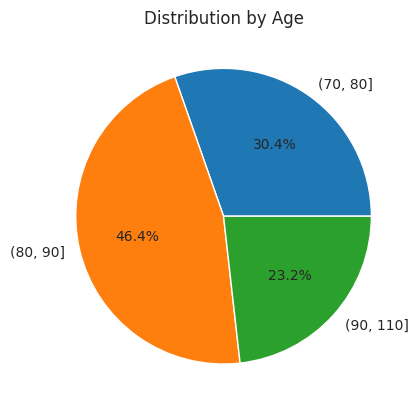

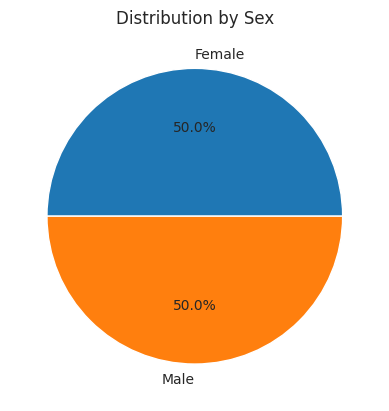

In [ ]:
plt.figure()

data_dict['Demographics'].groupby('age')['patient_id'].count().plot.pie(
    ylabel='',
    autopct='%1.1f%%',
    title='Distribution by Age',
)
plt.figure()
data_dict['Demographics'].groupby('sex')['patient_id'].count().plot.pie(
    ylabel='',
    autopct='%1.1f%%',
    title='Distribution by Sex',
)

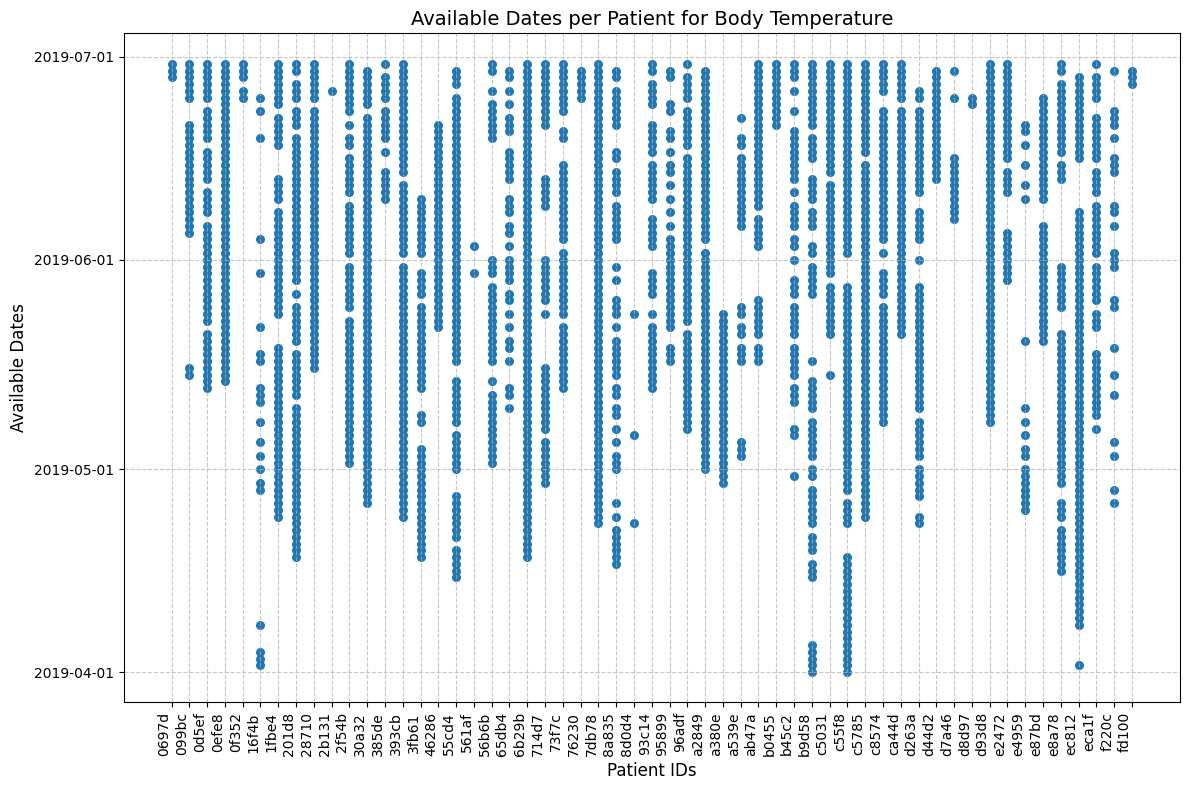

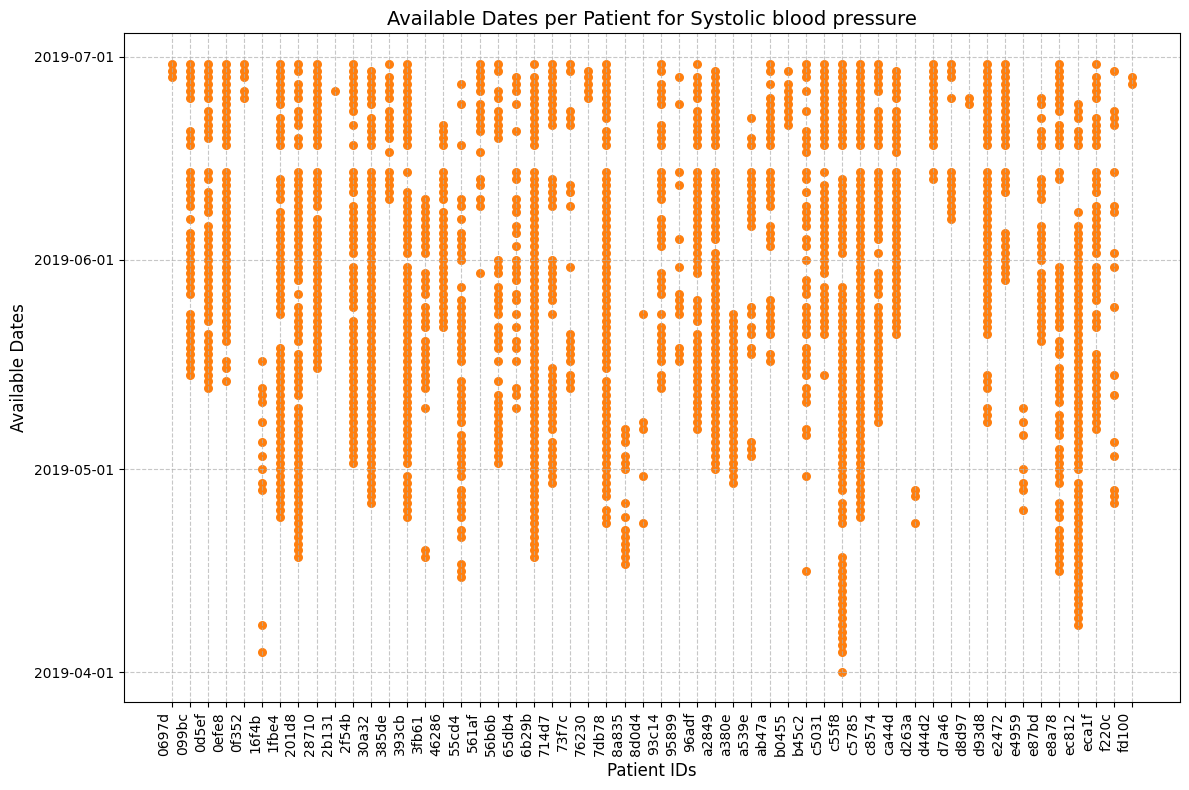

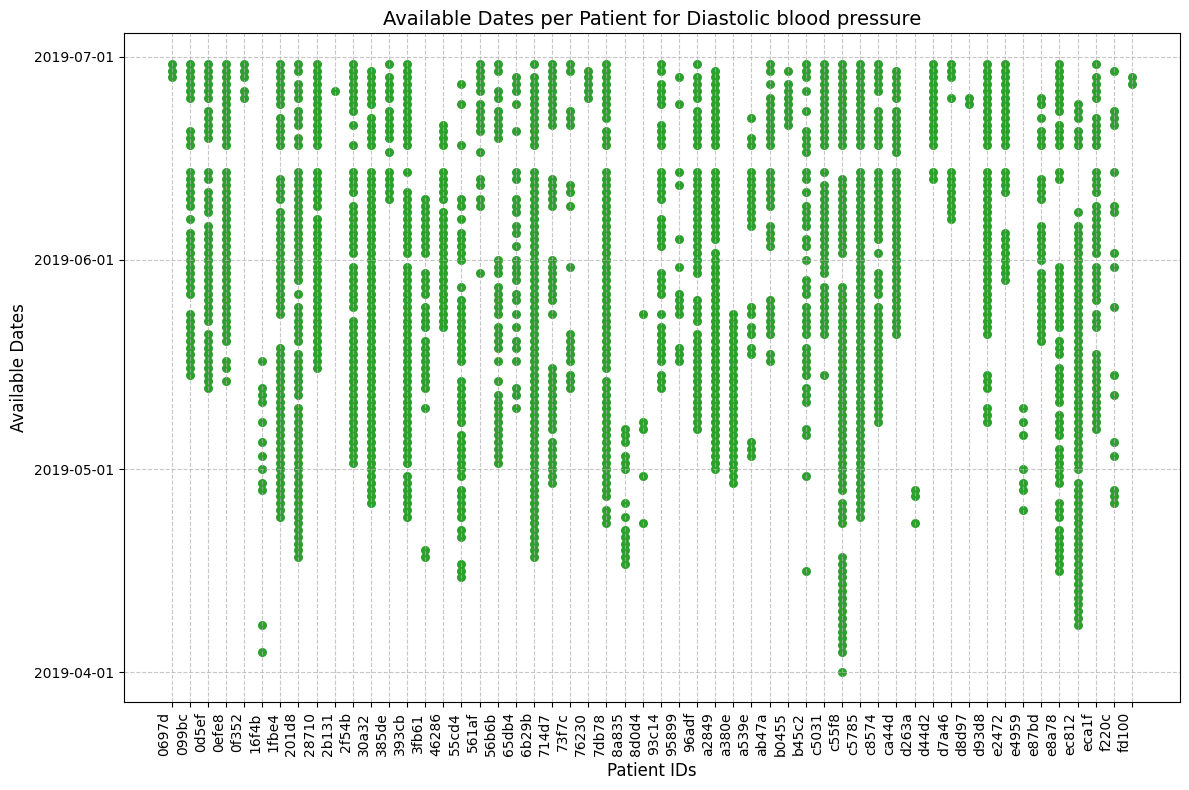

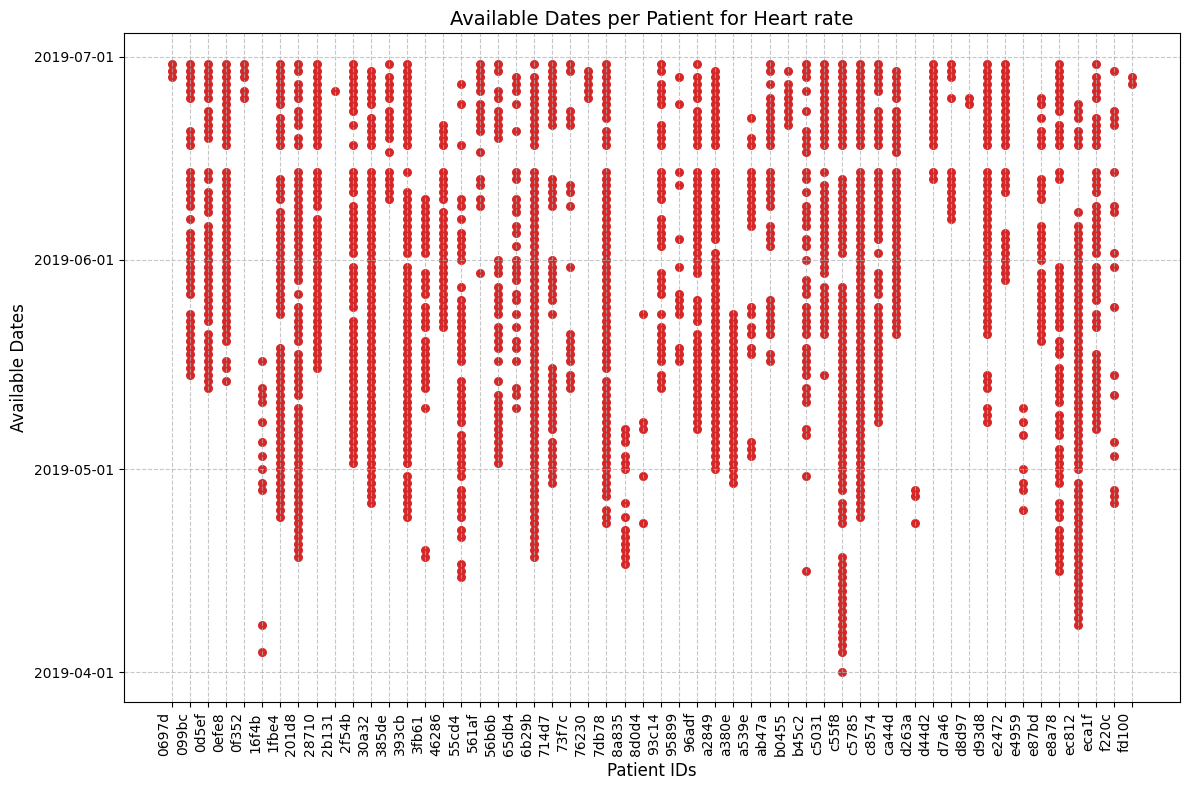

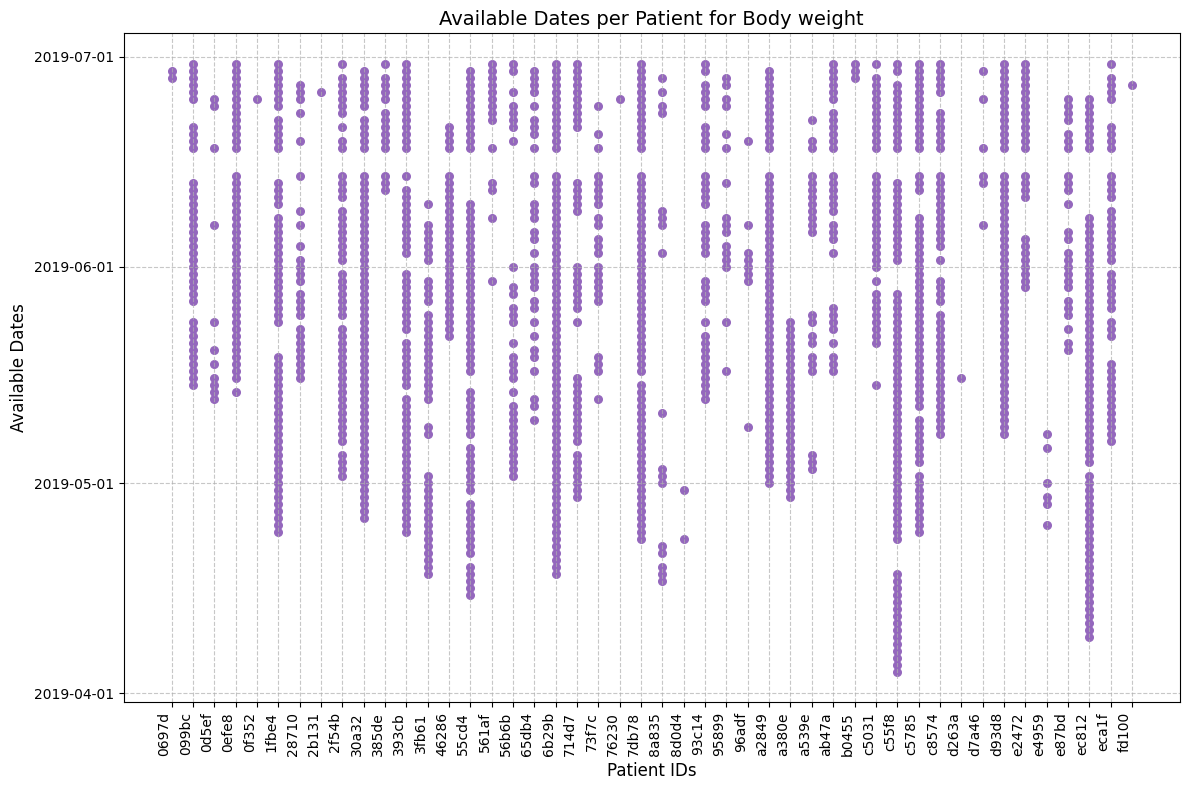

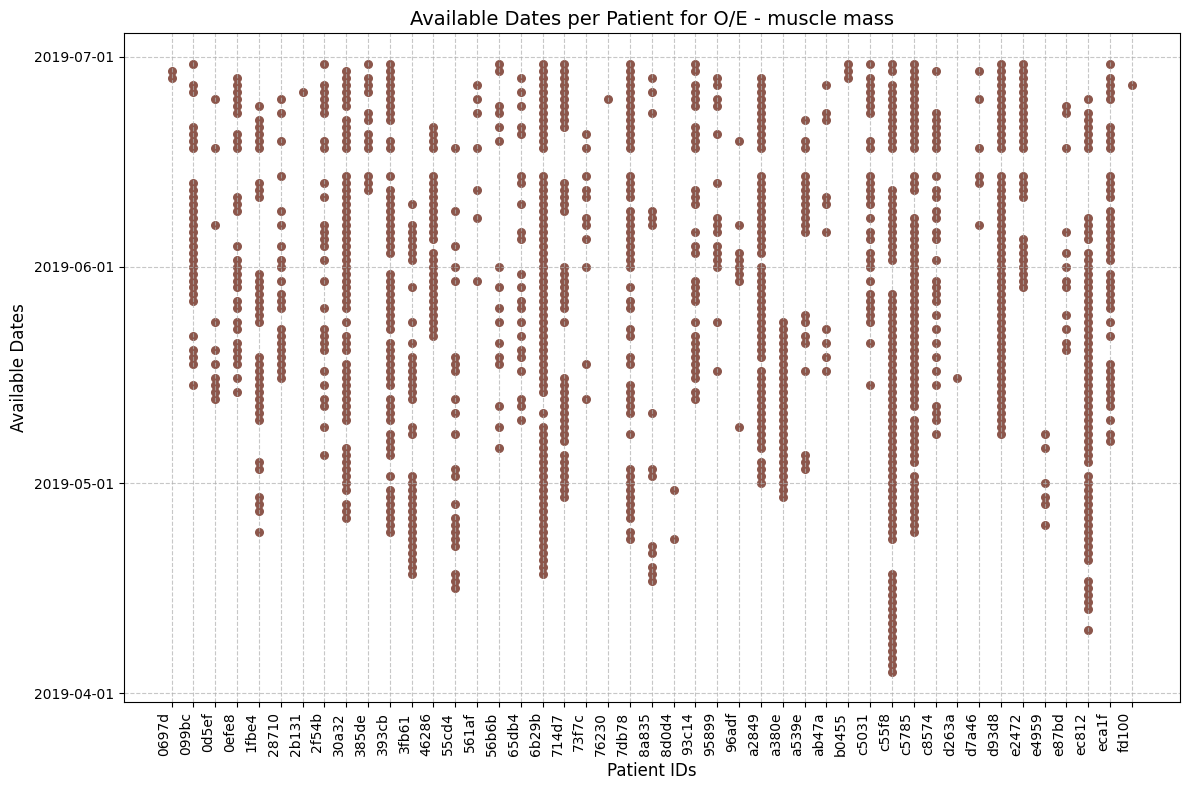

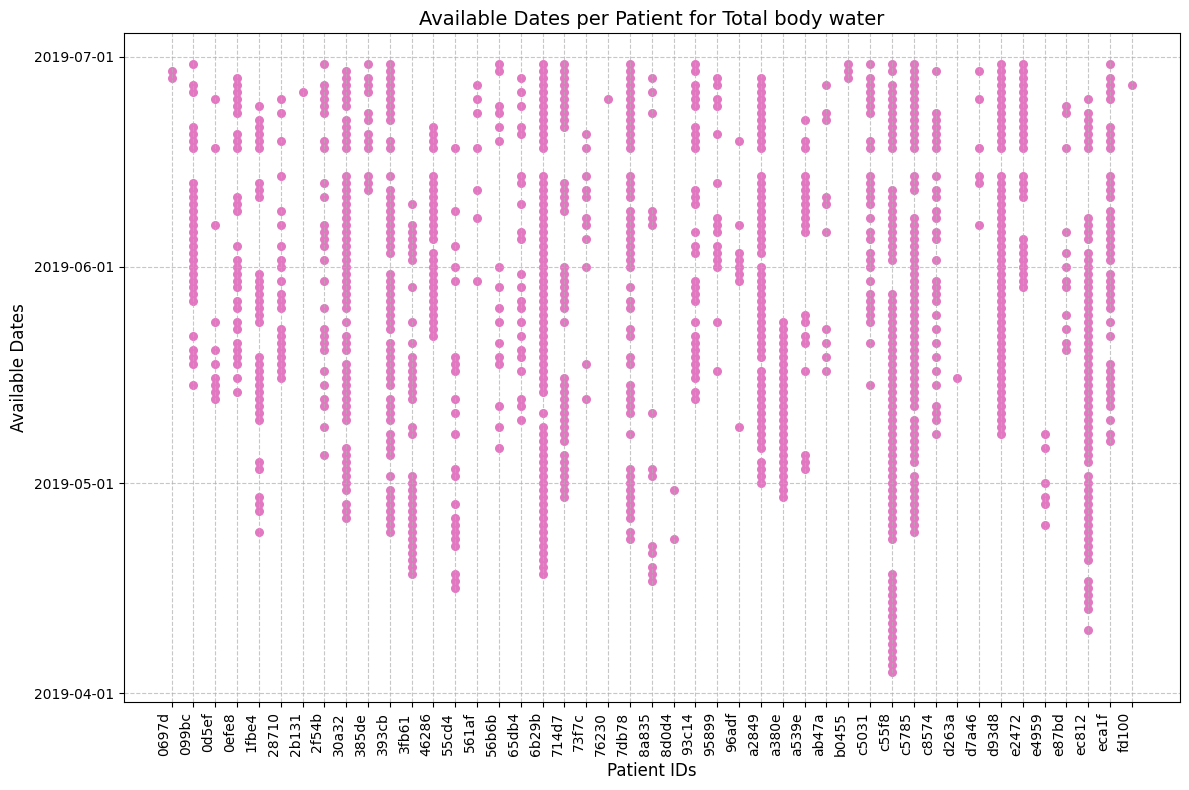

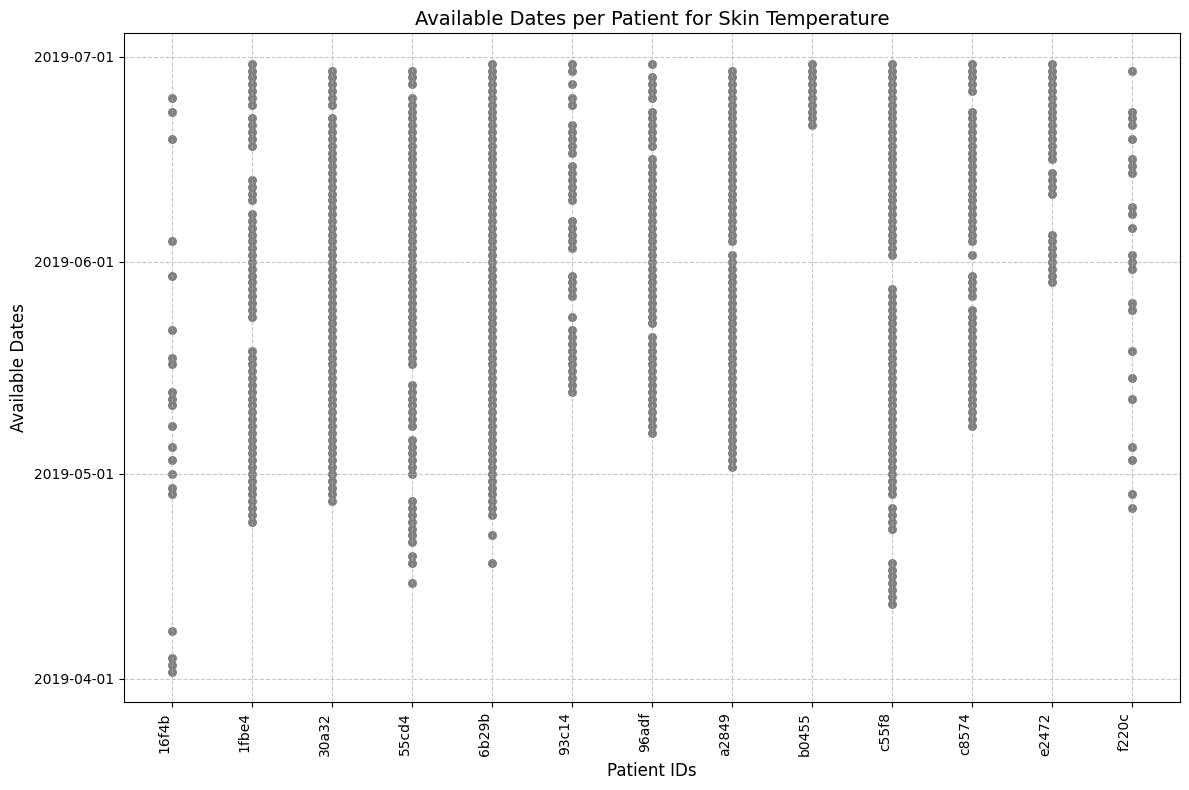

In [144]:
import pandas as pd

avai_dates = {}
for pid in patients:

  # Assuming 'data_dict' and 'get_personal_df' are defined earlier
  df = get_personal_df(data_dict['Physiology'],pid).copy()
  #print(df.date)
  date_min = df.date.min()
  date_max = df.date.max()
  #print(f'{pid} min {date_min}')
  #print(f'max{date_max}')
  date_range = pd.date_range(start=date_min,end=date_max,freq='1D')
  avai_dates_p = {}
  for d in df.device_type.unique():
    date_device = df.loc[df['device_type']==d].date.unique()
    avai_dates_p[d] = date_device.tolist()  # Available dates
  avai_dates[pid] = avai_dates_p

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create the plot figure

devices = data_dict['Physiology'].device_type.unique()  # Unique device types
colors = plt.cm.tab10.colors  # A colormap for assigning colors

# Loop through each device type
for i, d in enumerate(devices):

    fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size for better visualization

    data = {}
    for pid in patients:
        if d in avai_dates[pid].keys():
            data[pid] = avai_dates[pid][d]  # Collect avai dates for each patient-device pair

    # Prepare data for plotting
    patient_ids = list(data.keys())
    avai_dates_list = [avai_dates[pid][d] for pid in patient_ids]  # List of missed dates for each patient

    # Flatten the list of avai dates to plot each date individually
    all_patient_ids = []
    all_avai_dates = []

    for pid, avai_dates_for_pid in zip(patient_ids, avai_dates_list):
        all_patient_ids.extend([pid] * len(avai_dates_for_pid))  # Repeat patient ID for each missed date
        all_avai_dates.extend(avai_dates_for_pid)  # Flatten avai dates

    # Scatter plot for the current device
    ax.scatter(
        all_patient_ids,
        all_avai_dates,
        color=colors[i % len(colors)],
        label=d,
        s=30  # Adjust point size for better visibility
    )

    # Set axis labels and title
    ax.set_xlabel('Patient IDs', fontsize=12)
    ax.set_ylabel('Available Dates', fontsize=12)
    ax.set_title(f'Available Dates per Patient for {d}', fontsize=14)

    # Format y-axis as dates
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.yaxis.set_major_locator(mdates.MonthLocator())  # Adjust the locator to show months (or you can use DayLocator)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90, ha='right')

    # Display grid and adjust layout
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if d == 'O/E - muscle mass':
      d = 'muscle mass'
    plt.savefig(f'{SAVE_PATH}{d}.png')

    # Show the plot
    plt.show()


<Axes: xlabel='device_type'>

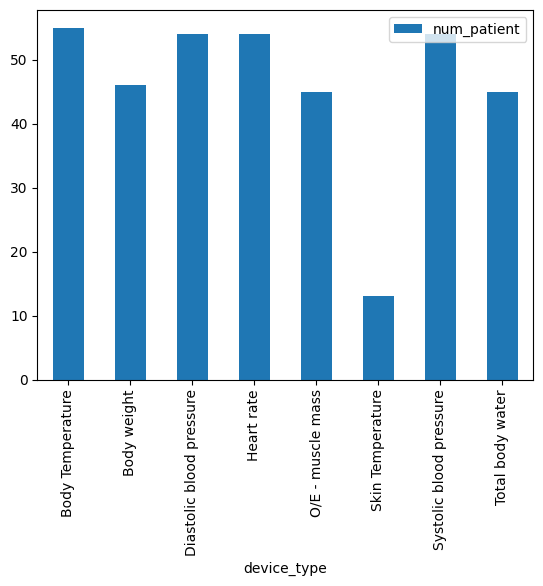

In [161]:
def count_patient(x):
  return x.nunique()
physio_df = data_dict['Physiology']
physio_df.groupby('device_type').agg(num_patient=('patient_id',count_patient)).plot.bar()

In [158]:
physio_df

,patient_id,timestamp,device_type,value,unit,date
0,0697d,2019-06-28 13:42:09,Body Temperature,36.072,Cel,2019-06-28
1,0697d,2019-06-28 13:42:44,Body Temperature,35.831,Cel,2019-06-28
2,0697d,2019-06-28 13:43:40,Body Temperature,35.831,Cel,2019-06-28
3,0697d,2019-06-28 13:45:15,Systolic blood pressure,165.000,mm[Hg],2019-06-28
4,0697d,2019-06-28 13:45:15,Diastolic blood pressure,82.000,mm[Hg],2019-06-28
...,...,...,...,...,...,...
17674,fd100,2019-06-28 21:09:27,Heart rate,61.000,beats/min,2019-06-28
17675,fd100,2019-06-28 21:32:19,Body Temperature,36.879,Cel,2019-06-28
17676,fd100,2019-06-28 21:32:46,Body Temperature,36.879,Cel,2019-06-28
17677,fd100,2019-06-29 21:05:11,Body Temperature,36.240,Cel,2019-06-29


In [142]:
SAVE_PATH

'/content/TIHM-Dataset-Visualization/Figs/'

In [ ]:
get_personal_df(data_dict['Activity'],p)

,patient_id,location_name,timestamp,date
0,0697d,Fridge Door,2019-06-28 13:03:29,2019-06-28
1,0697d,Kitchen,2019-06-28 13:11:44,2019-06-28
2,0697d,Front Door,2019-06-28 13:13:50,2019-06-28
3,0697d,Bedroom,2019-06-28 13:13:53,2019-06-28
4,0697d,Fridge Door,2019-06-28 13:14:09,2019-06-28
...,...,...,...,...
1030554,fd100,Hallway,2019-06-30 23:48:50,2019-06-30
1030555,fd100,Lounge,2019-06-30 23:49:40,2019-06-30
1030556,fd100,Kitchen,2019-06-30 23:50:02,2019-06-30
1030557,fd100,Front Door,2019-06-30 23:51:28,2019-06-30


In [ ]:
rows_with_nan.shape

(0, 5)

# Example of visualising the data
## For reproducing the results in the paper

In [ ]:
## Aggregate Physiology table
phys = data_dict['Physiology'].groupby(['patient_id','date','device_type'])[physio_df.select_dtypes(include=['number']).columns].agg('max')
phys.drop(phys.loc[phys.sum(axis=1)==0].index,axis=0,inplace=True)
phys.reset_index(inplace=True)
phys.head()

,patient_id,date,device_type,value
0,0697d,2019-06-28,Body Temperature,36.599
1,0697d,2019-06-28,Body weight,86.300
2,0697d,2019-06-28,Diastolic blood pressure,82.000
3,0697d,2019-06-28,Heart rate,42.000
4,0697d,2019-06-28,O/E - muscle mass,64.500
